In [ ]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
!pip install prophet


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

print("colab environment ready for Sales Forcasting")

colab environment ready for Sales Forcasting


In [ ]:
import pandas as pd
#loading Dataset
train_df=pd.read_csv('train.csv')
store_df=pd.read_csv('store.csv')

train_df.head(), store_df.head()


/tmp/ipython-input-2192460667.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df=pd.read_csv('train.csv')


(   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5  2015-07-31   5263        555     1      1            0   
 1      2          5  2015-07-31   6064        625     1      1            0   
 2      3          5  2015-07-31   8314        821     1      1            0   
 3      4          5  2015-07-31  13995       1498     1      1            0   
 4      5          5  2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  ,
    Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
 0      1         c          a               1270.0                        9.0   
 1      2         a          a                570.0                       11.0   
 2      3         a          a              14130.0                       12.0   
 3      4         c          c                620.0                  

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
#Merge store and train information
df=pd.merge(train_df,store_df,on ='Store',how='left')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
#COnvert data to datetime
df['Date']=pd.to_datetime(df['Date'])
#removing closed store days
df=df[df['Sales']>0]
df.shape

(844338, 18)

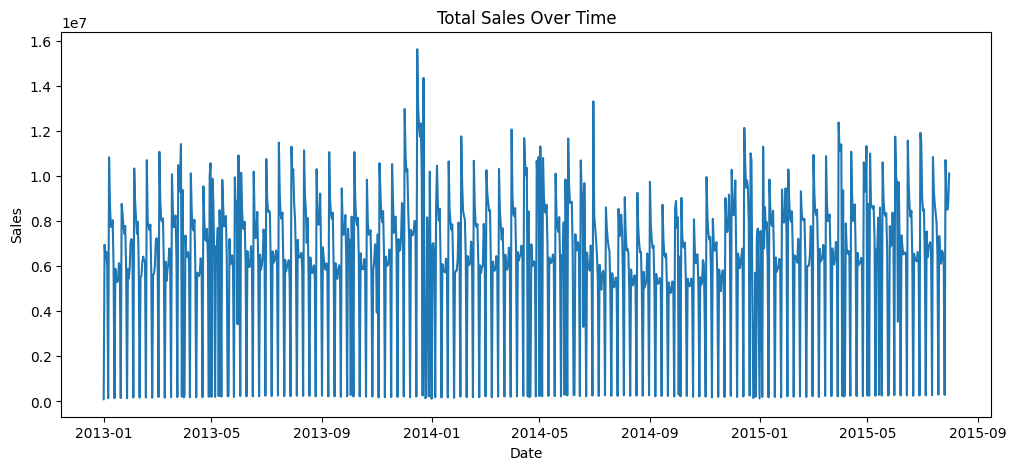

In [ ]:
import matplotlib.pyplot as plt

#aggregate daily sales
daily_sales = df.groupby('Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(daily_sales['Date'], daily_sales['Sales'])
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


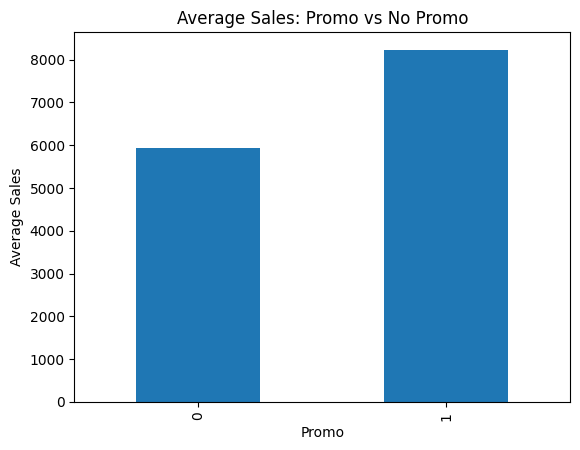

In [ ]:
promo_sales = df.groupby('Promo')['Sales'].mean()

promo_sales.plot(kind='bar', title='Average Sales: Promo vs No Promo')
plt.ylabel("Average Sales")
plt.show()#If promo = 1 has higher sales means promotions work

/tmp/ipython-input-2660054556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DayOfWeek'] = df['Date'].dt.dayofweek


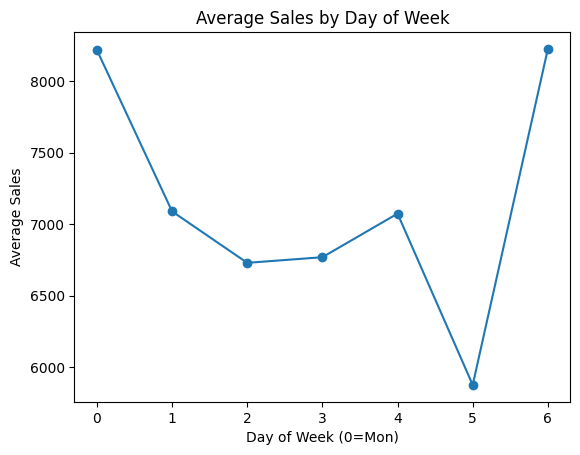

In [ ]:
df['DayOfWeek'] = df['Date'].dt.dayofweek

weekly_sales = df.groupby('DayOfWeek')['Sales'].mean()

weekly_sales.plot(kind='line', marker='o', title='Average Sales by Day of Week')
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average Sales")
plt.show()


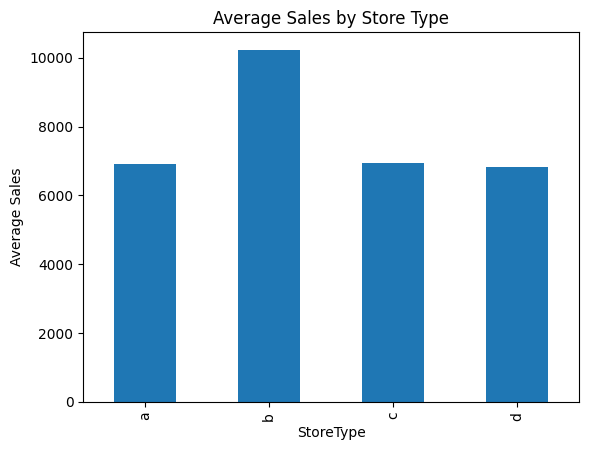

In [ ]:
#Store Tyoe Performance
store_type_sales = df.groupby('StoreType')['Sales'].mean()

store_type_sales.plot(kind='bar', title='Average Sales by Store Type')
plt.ylabel("Average Sales")
plt.show()


In [ ]:
#selecting one store for modeling
store_id=1

# Aggregate daily sales and promo status for each store
daily_store_sales = df.groupby(['Date', 'Store', 'Promo'])['Sales'].sum().reset_index()
daily_store_sales.rename(columns={'Date': 'ds', 'Sales': 'y', 'Promo': 'promo', 'Store': 'store'}, inplace=True)

store_df = daily_store_sales[daily_store_sales['store']==store_id]

store_df = store_df[['ds','y','promo']]
store_df.head()

,ds,y,promo
17,2013-01-02,5530,0
1128,2013-01-03,4327,0
2237,2013-01-04,4486,0
3345,2013-01-05,4997,0
4471,2013-01-07,7176,1


In [ ]:
#Building a Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

#Add promotion as external regressor
model.add_regressor('promo')

model.fit(store_df)

In [ ]:
#Create Future DataFrame
future=model.make_future_dataframe(periods=90) #This is 3 months of forecaste

#Assume no promotion in future
future['promo'] = 0

forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-02,5021.492072,4200.443490,5783.159602
1,2013-01-03,4771.927940,3964.948633,5601.452995
2,2013-01-04,4922.989763,4125.838479,5681.798275
3,2013-01-05,5662.137735,4882.524086,6559.694676
4,2013-01-07,4936.887760,4161.719852,5659.965336


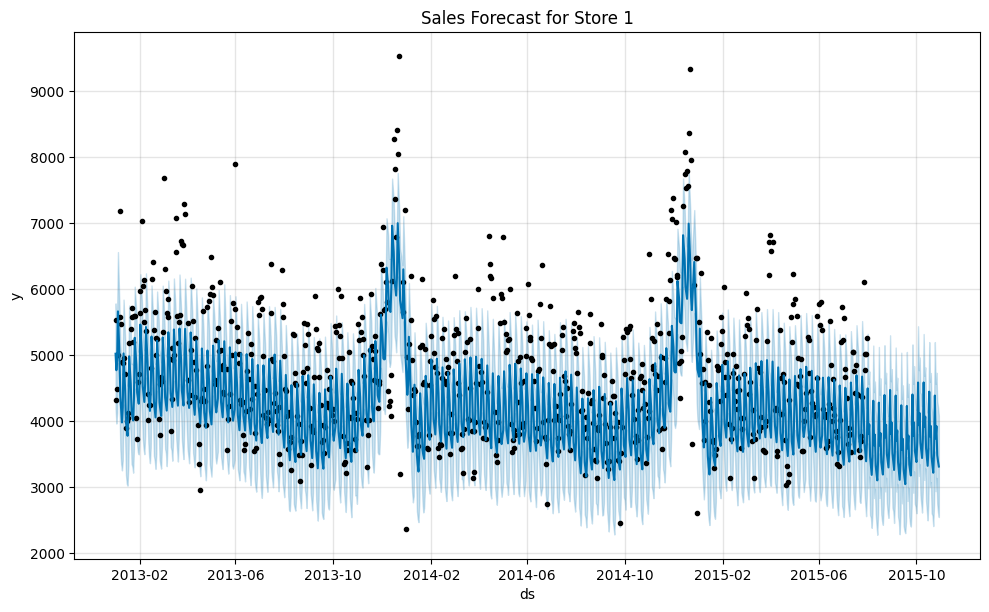

In [ ]:
#Visualize Forecast
model.plot(forecast)
plt.title(f"Sales Forecast for Store {store_id}")
plt.show()


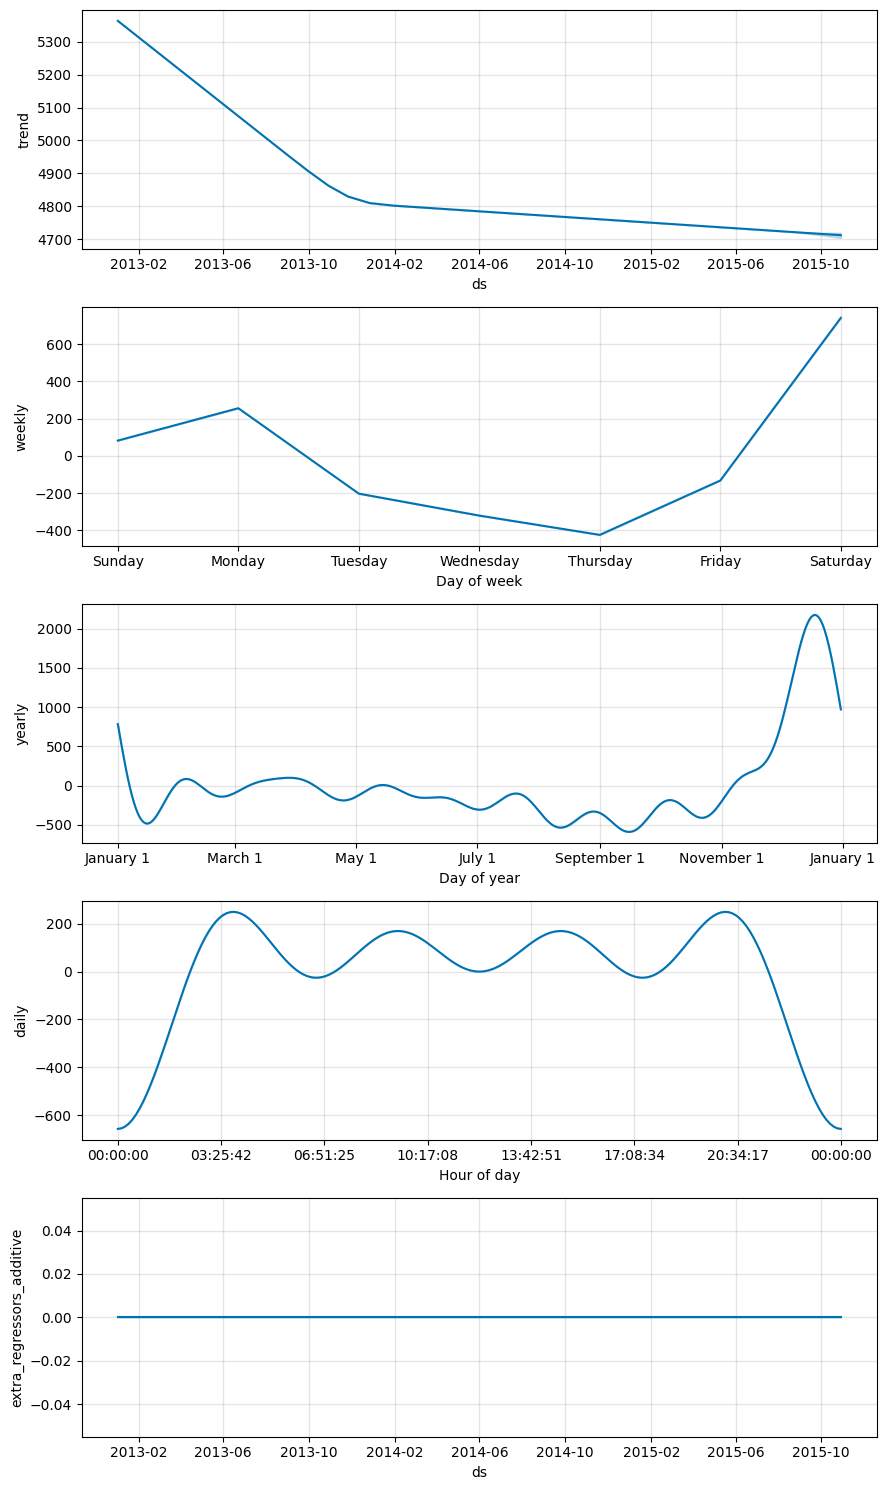

In [ ]:
#Forecast Components
model.plot_components(forecast)
plt.show()


In [ ]:
#Export Forecast Results
forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

forecast_output.to_csv(
    'store_1_sales_forecast.csv',
    index=False
)

print("Forecast CSV exported successfully")


Forecast CSV exported successfully


In [ ]:
#Prepare Actual vs Forecast Dataset
actual_sales = store_df[['ds', 'y']].rename(columns={'y': 'actual_sales'})

combined = actual_sales.merge(
    forecast_output,
    on='ds',
    how='left'
)

combined.to_csv('actual_vs_forecast.csv', index=False)
